# dora


dora is a light-weight python library with a RESTful API that provides a simple interface to powerful active sampling models.

The two core calls of any dora sampler are the `pick()` and an `update()` functions.

`pick()` asks the sampler to choose a set of parameters or a location in feature space where an observation would be the most beneficial based on a user-provided metric.

`update()` updates the sampler with the information obtained by an observation, allowing the sampler to propogate the knowledge through to all future predictions and `pick()` calls.


## Simple example ##
This demo aims to highlight dora's features and use cases.

Initially we will examine using the active sampling module as a python library to find the maximum of a non-convex function that is considered expensive to evaluate.

First, lets begin by importing the relevant packages

In [1]:
import numpy as np
import logging
from scipy.stats import norm
import dora.active_sampling as sampling
import time
from dora.active_sampling import pltutils
from dora.active_sampling.acquisition_functions import VarSum
import matplotlib.pyplot as pl
import matplotlib as mpl
%matplotlib inline


### Problem Setup ###

Next we define a 1-D function, `ground_truth()`, that is unknown to the user but that can be evaluated when given an input variable, `x`. 

In [2]:
def ground_truth(X):
    return np.sin(X-5) + np.sin(X/2-2) + 0.4*np.sin(X/5-2) + 0.4*np.sin(X-3) + 0.2*np.sin(X/0.3-3)

Next we need to set the bounds for the problem. In this example, the space is one dimensional. So the upper and lower bounds will both be lists with one element in each.

In [3]:
# Set up a problem bounds
lower = [0]
upper = [30]

For illustrative purposes, lets plot the latent function, `ground_truth()`, over a range of x.

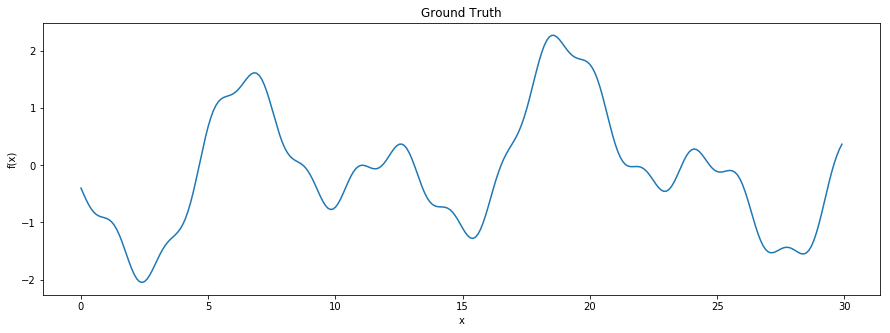

In [4]:
x = np.arange(0,30,0.1)
fx = ground_truth(x)
pl.figure(figsize=(15,5))
pl.plot(x,fx); 
pl.xlabel('x')
pl.ylabel('f(x)')
pl.title('Ground Truth')
pl.show()

### Initialise the Sampler ###


If we provide the sampler with no initial data, it must first randomly sample the underlying function to build an approximate model of its behaviour before it can begin suggesting new points to observe. Consequently we specify the number of random samples it should acquire before training a model.


In [5]:
n_train = 8

The sampler uses an acquisition function to determine what the next most beneficial datapoint to obtain would be. The quantification of the benefit varies from application to application. As a result, the user is free to provide their own acquisition function or choose an existing one from the dora library.

In this instances, `pred_upper_bound`, an aquisition function which is the predicted upper bound of the sampler's model will be used.

In [6]:
acq_fn = VarSum()

We also set an explore_priority scalar. The larger this value, the more the sampler will seek to explore areas of the parameter space with sparse observations rather than attempting to refine an area where the model believes will maximise it's objective function.

In [7]:
explore_priority = 1.

When initialising the sampler, we specify the class of the model it will base its predictions on. In this case, it's the Gaussian process. Seeding the model is unnecessary unless the user desires a repeatable set of initial picks prior to training.

In [8]:
sampler = sampling.GPflowSampler(lower, upper, acquisition_function=acq_fn,
                                           n_train=n_train, seed=11)
    

### Active sampling strategy

`sampler.pick()` is used to get the parameters which the sampler would like you to observe. The first few picks (n_train) from the sampler are randomly distributed in the parameter space in order to acquire a 
representative dataset to train the model.
As well as a set of parameters (`xq`), `sampler.pick()` also returns an associated unique identification number `uid` which is required later when the user wishes to update the model with the value of the observation made at `xq`. 

In [9]:
xq, uid = sampler.pick()
print('Parameter:',xq)
print('Unique ID:',uid)

Parameter: [ 5.40809067]
Unique ID: d8d5e81151974527a8da04b86e5888ac


The user can then evaluate their system using the acquired parameters.

In [10]:
yq_true = ground_truth(xq)
print('Observation value:', yq_true)

Observation value: [ 1.12001909]


The sampler can then be updated using the `sampler.update()` function and passing in the observation with the parameters associated UID.

In [11]:
# Update the sampler about the new observation
sampler.update(uid, yq_true)
print('Sampler has been updated with the new observation value')

Sampler has been updated with the new observation value


Lets request the parameter values of the remaining training points and update the sampler with the corresponding observated values.

In [12]:
print(sampler.y_mean)
for i in range(n_train-1):
    xq, uid = sampler.pick()
    yq_true = ground_truth(xq)
    sampler.update(uid, yq_true)
    print(sampler.y_mean)

[ 1.12001909]
[ 0.1329185]
[-0.14736327]
[-0.11578633]
[-0.01804983]
[-0.14853555]
[-0.23447789]
[-0.30889769]


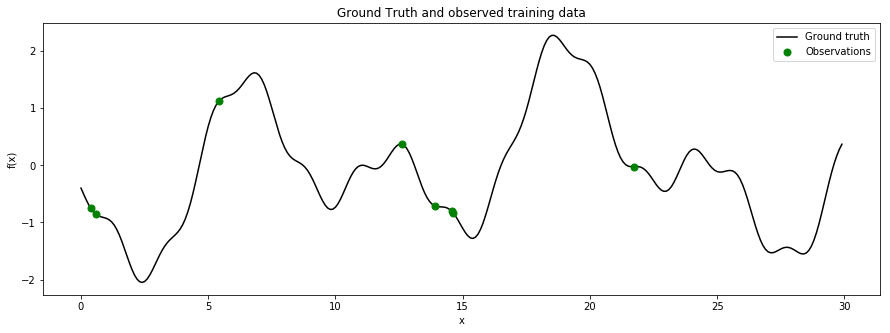

In [13]:
pl.figure(figsize=(15,5))
pl.plot(x,fx,'k'); 
pl.plot(sampler.X, sampler.y,'go', markersize=7)
#pl.plot(sampler.X[-1], sampler.y[-1],'ro', markersize=10)
pl.xlabel('x')
pl.ylabel('f(x)')
pl.title('Ground Truth and observed training data')
pl.legend(('Ground truth', 'Observations'))
pl.show()

The sampler now has enough data to train a model of the function which it will do if it receives another request.

In [14]:
len(sampler.X())

8

In [15]:
xq, uid = sampler.pick()

name.likelihood.variance transform:+ve prior:None
[ 1.]
name.kern.variance transform:+ve prior:None
[ 1.]
name.kern.lengthscales transform:+ve prior:None
[ 1.]

name.likelihood.variance transform:+ve prior:None
[ 0.00070593]
name.kern.variance transform:+ve prior:None
[ 0.5446781]
name.kern.lengthscales transform:+ve prior:None
[ 1.27242628]



In [16]:
sampler.params['name.mean_function.c'] = np.array([sampler.y_mean])

In [17]:
sampler.gpr.get_free_state()

array([-7.25706044, -0.32289263,  0.94371098])

Once the sampler is trained, it provides the user with a new parameter value to assess their query the ground truth with. The value of this parameter was determined using the sampler's internal probabilitic model of the ground truth and the acquistion function provided during initialisation. In the plot below it is represented by the red circle. The mean function and standard deviation function of the sampler's probabilistic model of the ground truth is shown as the blue dashed line and blue shaded area, respectively. 

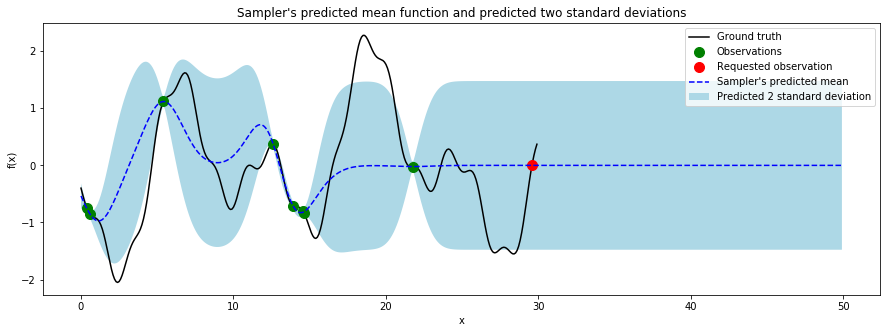

In [18]:
xquery = x[:,np.newaxis]
xquery = np.arange(0,50,0.1)[:,np.newaxis]
mf, vf = sampler.predict(xquery)

#mf = mf - sampler.y_mean

pl.figure(figsize=(15,5))
pl.plot(x,fx,'k'); 
pl.plot(sampler.X[:-1], sampler.y[:-1],'go', markersize=10)
pl.plot(sampler.X[-1], sampler.y[-1],'ro', markersize=10)
pl.plot(xquery, mf,'b--')
y1 = mf - np.sqrt(vf)*2
y2 = mf + np.sqrt(vf)*2
pl.fill_between(xquery[:,0], y1[:,0], y2[:,0], where=(y2 >= y1)[:,0], facecolor='lightblue')

pl.xlabel('x')
pl.ylabel('f(x)')
pl.legend(('Ground truth', 'Observations', "Requested observation", "Sampler's predicted mean",'Predicted 2 standard deviation'))
pl.title("Sampler's predicted mean function and predicted two standard deviations")
pl.show()

In [19]:
sampler.params

{'name.kern.lengthscales': array([ 1.27242628]),
 'name.kern.variance': array([ 0.5446781]),
 'name.likelihood.variance': array([ 0.00070593]),
 'name.mean_function.c': array([[-0.30889769]])}

In [20]:
sampler.y_mean

array([-0.30889769])

Examining the values of the acquistion function below shows why the sampler requested an observation for that specific parameter value. ie. it is the acquistion function's maximum.

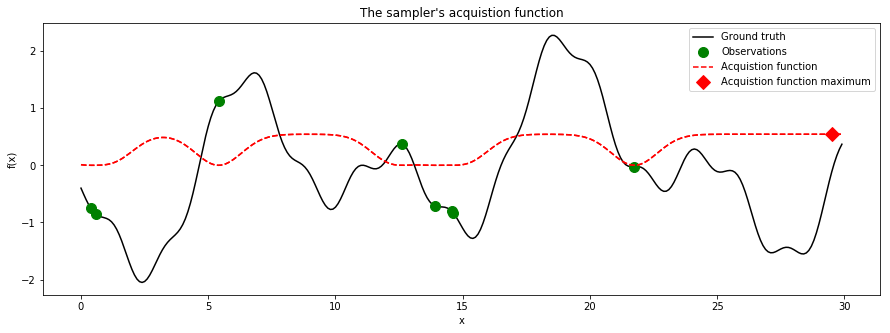

In [21]:
acq_value, acq_max_ind = sampler.eval_acq(x)

pl.figure(figsize=(15,5))
pl.plot(x,fx,'k'); 
pl.plot(sampler.X[:-1], sampler.y[:-1],'go', markersize=10)
pl.plot(x, acq_value,'r--')
pl.plot(x[acq_max_ind], acq_value[acq_max_ind],'rD', markersize=10)
pl.plot(x, acq_value,'r--')
pl.xlabel('x')
pl.ylabel('f(x)')
pl.title("The sampler's acquistion function")
pl.legend(('Ground truth', 'Observations', 'Acquistion function', 'Acquistion function maximum') )
pl.show()

You can run the cell below a number of times to iterate through the `pick()` and `update()` iterations while the sampler searches for the system of interest's maximum value.

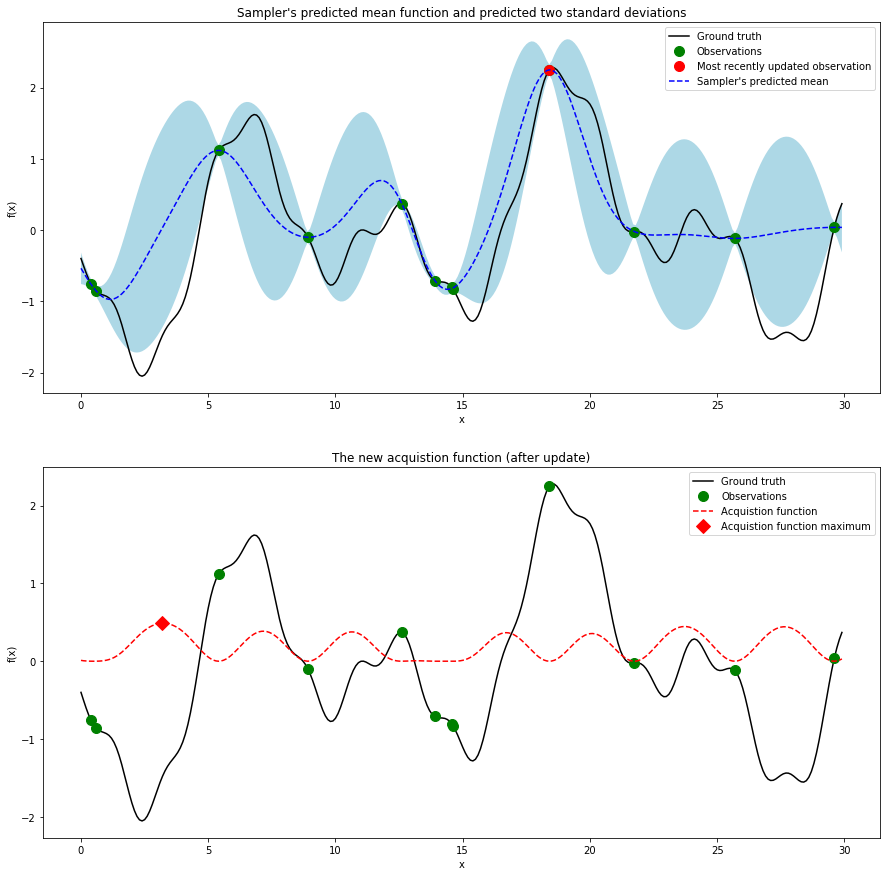

In [25]:
# Observe the value of the system of interest using the requested parameter value.
yq_true = ground_truth(xq)

# Update the sampler about the new observation
sampler.update(uid, yq_true)

# Plot the results
xquery = x[:,np.newaxis]
mf, vf = sampler.predict(xquery)
pl.figure(figsize=(15,15))
pl.subplot(2,1,1)
pl.plot(x,fx,'k'); 
pl.plot(sampler.X, sampler.y,'go', markersize=10)
pl.plot(sampler.X[-1], sampler.y[-1],'ro', markersize=10)
pl.plot(xquery, mf,'b--')
y1 = mf - np.sqrt(vf)*2
y2 = mf + np.sqrt(vf)*2
pl.fill_between(xquery[:,0], y1[:,0], y2[:,0], where=(y2 >= y1)[:,0], facecolor='lightblue')
pl.xlabel('x')
pl.ylabel('f(x)')
pl.legend(('Ground truth', 'Observations', "Most recently updated observation", "Sampler's predicted mean"))
pl.title("Sampler's predicted mean function and predicted two standard deviations")

# Visualise the acquistion function
acq_value, acq_max_ind = sampler.eval_acq(x)
pl.subplot(2,1,2)
pl.plot(x,fx,'k'); 
pl.plot(sampler.X, sampler.y,'go', markersize=10)
pl.plot(x, acq_value,'r--')
pl.plot(x[acq_max_ind], acq_value[acq_max_ind],'rD', markersize=10)
pl.xlabel('x')
pl.ylabel('f(x)')
pl.title("The new acquistion function (after update)")
pl.legend(('Ground truth', 'Observations', 'Acquistion function', 'Acquistion function maximum') )

pl.show()

#Request a new parameter value to observe
xq, uid = sampler.pick()
